#Imports и поверхностное изучение датасета

In [1]:
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.metrics import ndcg_score
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

warnings.filterwarnings('ignore')

Заргузим данные, предварительно залитые на гугл диск:

In [2]:
from google.colab import drive
drive.mount('/drive')
path = "/drive/MyDrive/DS/RecSys"

!mkdir data
!cp -a /$path/. data

Mounted at /drive


In [3]:
!7z e "data/members.csv.7z"
!7z e "data/songs.csv.7z"
!7z e "data/test.csv.7z"
!7z e "data/train.csv.7z"
!7z e "data/song_extra_info.csv.7z"
!7z e "data/sample_submission.csv.7z"


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1349856 bytes (1319 KiB)

Extracting archive: data/members.csv.7z
--
Path = data/members.csv.7z
Type = 7z
Physical Size = 1349856
Headers Size = 130
Method = LZMA2:3m
Solid = -
Blocks = 1

  0%    Everything is Ok

Size:       2503827
Compressed: 1349856

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 105809525 bytes (101 MiB)

Extracting archive: data/songs.csv.7z
--
Path = data/songs.csv.7z
Type = 7z
Physical Size = 105809525
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1


Посмтрим на все таблицы кроме test(так как нам он не понадобится):

In [4]:
members = pd.read_csv("members.csv")
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [5]:
songs = pd.read_csv("songs.csv")
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [6]:
songs_extra = pd.read_csv("song_extra_info.csv")
songs_extra.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [7]:
data = pd.read_csv("train.csv")
data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


Посмотрим на возможные значения target:

In [8]:
data['target'].value_counts()

target
1    3714656
0    3662762
Name: count, dtype: int64

Заетим, что в графе target у нас стоит 1, если в течение месяц пользователь повторно прослушал трек, и 0 в противном случае. Причем других значений нету(например Nan-ов). Но в нашей задаче надо построить рекомендательную систему(то есть отранжировать релевантные). А в исходной задаче(в соревновании на kaggle, откуда брались данные) необходио было для тестовой части тоже предсказать, будет ли повторное прослушиввание в течение следующего месяца. То есть задачи сильно отличаются, причем для задачи рекомендаций должно быть как положительное сэмплирование, так и негативное. Поэтому проинтерпертируем target по-другому: если значение равно 1(то есть пользователь прослушал хотя бы два раза), то будем считать взаимодействие положительным, а в противном случае негативным.

Сделаем совмещенную таблицу, сконкатенировав все в одну:

In [9]:
songs_full_info = pd.merge(songs, songs_extra, on='song_id', how='left')
songs_full_info.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0,焚情,TWB531410010
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,PLAYING WITH FIRE,NaN
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0,SORRY| SORRY,NaN
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0,愛我的資格,TWC950206108
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0,Mary Had a Little Lamb,NaN


Добавим информацию о каждом треке:

In [10]:
data = pd.merge(data, songs_full_info, on='song_id', how='left')
data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,Good Grief,GBUM71602854
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,NaN,52.0,Lords of Cardboard,US3C69910183
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,Disco Africa,GBUQH1000063
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,Sleep Without You,QM3E21606003


Добавим информацию о каждом пользователе:

In [11]:
data = pd.merge(data, members, on='msno', how='left')
data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,Good Grief,GBUM71602854,1,0,NaN,7,20120102,20171005
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,NaN,52.0,Lords of Cardboard,US3C69910183,13,24,female,9,20110525,20170911
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,20110525,20170911
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,Disco Africa,GBUQH1000063,13,24,female,9,20110525,20170911
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,Sleep Without You,QM3E21606003,1,0,NaN,7,20120102,20171005


Посмтоим вообще на количество незаполненных значений в датасете(красивую интрепертацию я взял из открытых ноутбуков на kaggle)

In [12]:
def check_values(data):
    dtypes = pd.DataFrame(data.dtypes,columns=["Data Type"])
    dtypes["Unique Values"]=data.nunique().sort_values(ascending=True)
    dtypes["Null Values"]=data.isnull().sum()
    dtypes["% null Values"]=100*data.isnull().sum()/len(data)
    return dtypes.sort_values(by="Null Values" , ascending=False).style.background_gradient(cmap='YlOrRd',axis=0)

In [13]:
result = check_values(data)
result

,Data Type,Unique Values,Null Values,% null Values
lyricist,object,33887,3178812,43.088408
gender,object,2,2961479,40.142486
composer,object,76064,1675706,22.713990
isrc,object,269720,577963,7.834218
source_screen_name,object,20,414804,5.622618
genre_ids,object,572,118455,1.605643
source_system_tab,object,8,24849,0.336825
source_type,object,12,21539,0.291959
name,object,234111,1571,0.021295
language,float64,10,150,0.002033


Стоит не брать в рассчет колонку gender, так как процент незаполненных значений около 40, но при этом восстановить ихх невозможно. В колонке lyricist процент незаполненных знаений еще выше, но данные о композиторе могут помочь с определением сходства песен, поэтому просто заполним их рандомными значениями(нельзя заполнять одним по типу Nall, так как мы можем добавить лишние закономерности). Аналогично с колонкой composer. В отсальных процент незаполненных значений очень маленький.

#Анализ данных

**Исследуем распределение треков по их длинам**

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
data1 = songs[songs['song_length'] > 0.7*1e6]
data1.shape

(24630, 7)

Треков длинее 700000ms очень мало по сравнению со всей выборкой (в районе 1%), поэтому, чтобы гистограама не растягивалась не будем выводить их

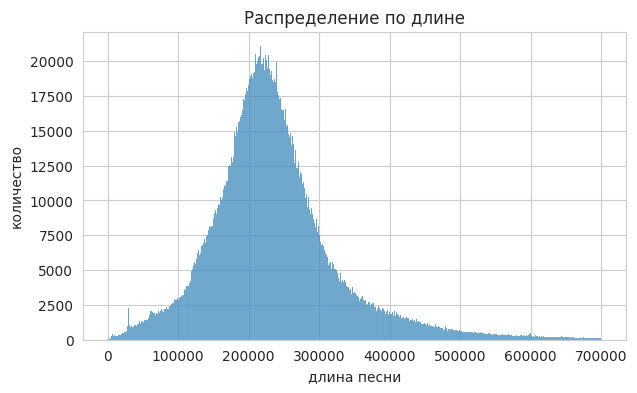

In [49]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(7, 4))
    hist = sns.histplot(data=songs[songs['song_length'] < 0.7 * 1e6], x='song_length')


    plt.title('Распределение по длине')
    plt.xlabel('длина песни')
    plt.ylabel('количество')

Как мы можем наблюдать, большенство треков имеют длину от 100000ms до 400000ms. Пик приходится на 210000ms

**Посмотрим на языки исполнения треков**

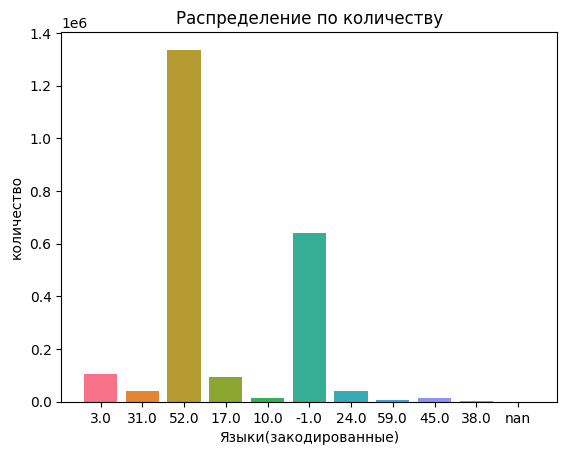

In [50]:
from collections import Counter


lang_total = dict(Counter(songs.language))

ind = np.arange(len(lang_total))
palette = sns.color_palette("husl", len(lang_total))

plt.bar(ind, list(lang_total.values()), color=palette)
plt.xticks(ind, list(lang_total.keys()))
plt.title('Распределение по количеству')
plt.xlabel('Языки(закодированные)')
plt.ylabel('количество')
plt.show()

Больше всего песен на языке под кодом 52, вероятно это английский.

-1 и nan скорее всего неопределенные языки

**Посмотрим на жанры**

In [51]:
genre_total = dict(Counter(songs.genre_ids))

a = list(genre_total.keys())
a = [str(i).split('|') for i in a]
b = [i[0] for i in a if len(i) == 1]

genre_total = {}


for g_all in a:
    for g in g_all:
        try:
            genre_total[g] = 0
        except:
            genre_total[g] = 0
print(len(genre_total))

192


In [52]:
genre = songs[['genre_ids', 'song_length']].copy()

genre['genre_ids'] = genre['genre_ids'].apply(lambda x: str(x).split('|'))

In [53]:
for g_all in genre['genre_ids']:
    for g in g_all:
        genre_total[g] += 1

sorted_genre_total = dict(sorted(genre_total.items(), key=lambda item: item[1], reverse=True))
sorted_genre_total

{'465': 589220,
 '958': 182836,
 '1609': 177258,
 '2022': 176531,
 '2122': 149608,
 '1259': 103904,
 'nan': 94116,
 '921': 74983,
 '1152': 65463,
 '786': 59438,
 '139': 56405,
 '359': 48144,
 '940': 45604,
 '726': 36766,
 '1011': 34620,
 '947': 30232,
 '388': 27608,
 '1572': 27311,
 '1616': 26983,
 '275': 25808,
 '1955': 21426,
 '109': 20659,
 '873': 20513,
 '691': 20248,
 '125': 18733,
 '458': 17857,
 '437': 17441,
 '444': 16097,
 '880': 15430,
 '242': 14476,
 '451': 13391,
 '829': 13155,
 '423': 12302,
 '2130': 11586,
 '2086': 11393,
 '1180': 11120,
 '1138': 11050,
 '2058': 10307,
 '374': 8849,
 '843': 8413,
 '864': 8393,
 '850': 8382,
 '893': 7778,
 '857': 7693,
 '430': 7507,
 '2072': 7344,
 '798': 7104,
 '409': 6568,
 '352': 5706,
 '1995': 4974,
 '2107': 4967,
 '698': 4851,
 '94': 4714,
 '545': 4609,
 '381': 4469,
 '2079': 3924,
 '2093': 3881,
 '822': 3668,
 '1633': 3510,
 '1145': 3253,
 '118': 2703,
 '2189': 2674,
 '367': 2154,
 '900': 2110,
 '1977': 1908,
 '1096': 1871,
 '2176': 

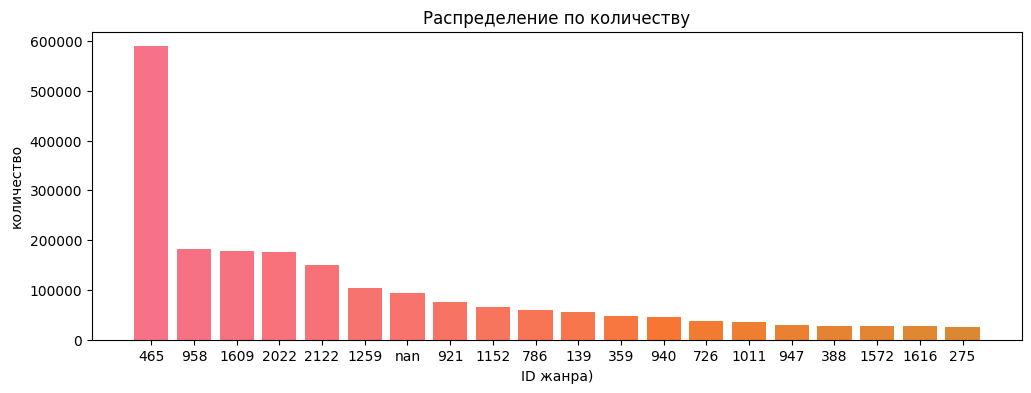

In [54]:
ind = np.arange(20)
palette = sns.color_palette("husl", len(sorted_genre_total))

plt.figure(figsize=(12, 4))

plt.bar(ind, list(sorted_genre_total.values())[0:20], color=palette)
plt.xticks(ind, list(sorted_genre_total.keys())[0:20])
plt.title('Распределение по количеству')
plt.xlabel('ID жанра)')
plt.ylabel('количество')
plt.show()

На гистограмме показаны наиболее популярные 20 жанров музыки. Как видно, самый популярный это 465, так же можно заметить, что довольно много треков с неизвестным жанром nan

**Частые исполнители**

In [55]:
name_total = dict(Counter(songs.artist_name)) #artist_name
sorted_name_total = dict(sorted(name_total.items(), key=lambda item: item[1], reverse=True))
sorted_name_total

{'Various Artists': 145916,
 '証聲音樂圖書館 ECHO MUSIC': 11276,
 'Billy Vaughn': 4828,
 'รวมศิลปิน': 4432,
 'Richard Clayderman': 4180,
 'Elvis Presley': 4038,
 'Nat King Cole': 3806,
 'Billie Holiday': 3674,
 'Frank Sinatra': 3594,
 'Armin van Buuren': 2818,
 'Various': 2742,
 'Ella Fitzgerald': 2721,
 'オルゴールサウンド J-POP': 2692,
 'Glenn Gould': 2689,
 'Bill Evans': 2572,
 'Chet Baker': 2532,
 '鄧麗君 (Teresa Teng)': 2487,
 'Bob Dylan': 2471,
 '貴族精選': 2419,
 'Ray Charles': 2235,
 'The Kiboomers': 2230,
 'Michael Jackson': 2208,
 'Miles Davis': 2179,
 'Falcom Sound Team jdk': 2164,
 'Louis Armstrong': 2161,
 'Wolfgang Amadeus Mozart': 2047,
 'Andy Williams': 1995,
 'Power Music Workout': 1987,
 '霹靂布袋戲劇集原聲帶': 1905,
 'Julie London': 1838,
 'Yo-Yo Ma': 1824,
 'John Williams': 1774,
 'Frederic Chopin': 1724,
 'Antonio Vivaldi': 1724,
 'B.B. King': 1706,
 'DJ ReMix Factory': 1623,
 'New York Jazz Lounge': 1605,
 "The O'Neill Brothers Group": 1596,
 '勁樂音樂Big Bang& Fuzz': 1578,
 'The Karaoke Channel': 15

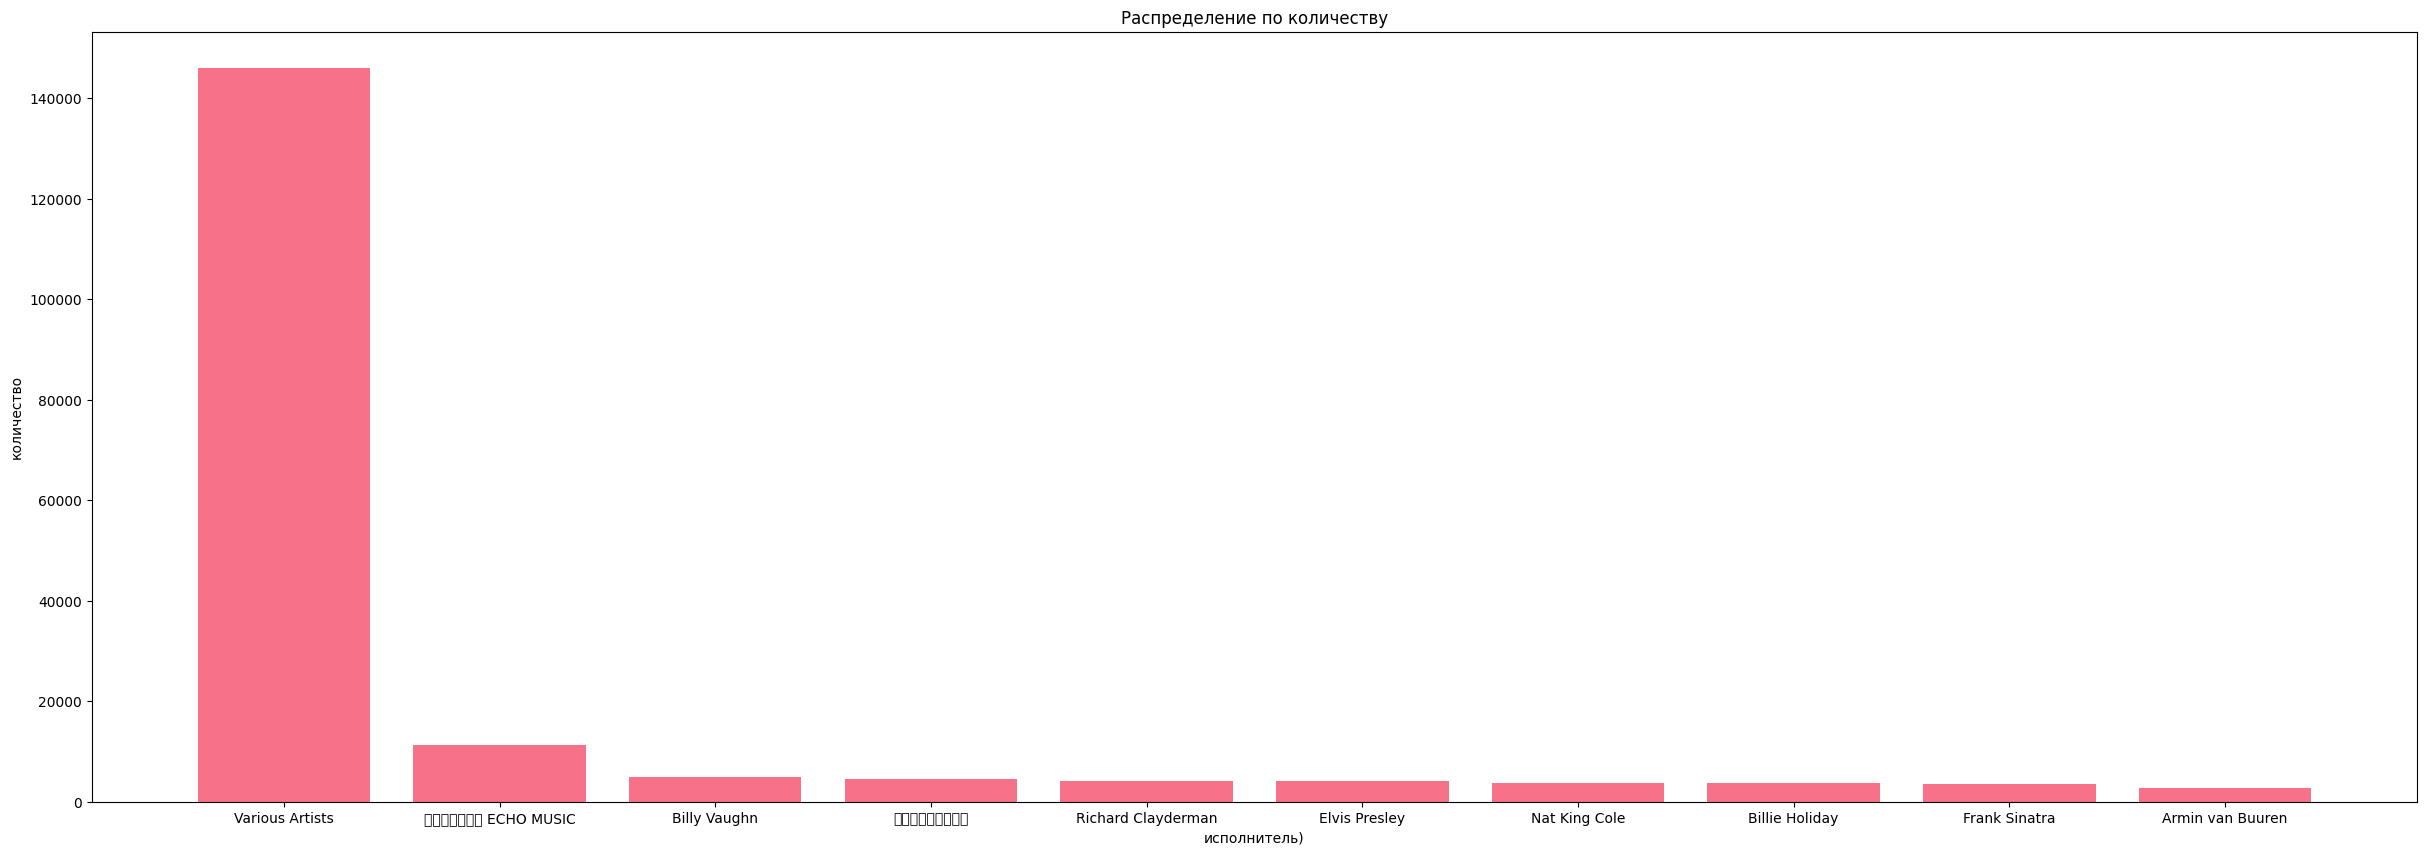

In [56]:
ind = np.arange(10)
palette = sns.color_palette("husl", len(sorted_name_total))

plt.figure(figsize=(30, 10))

plt.bar(ind, list(sorted_name_total.values())[0:10], color=palette)
plt.xticks(ind, list(sorted_name_total.keys())[0:10])
plt.title('Распределение по количеству')
plt.xlabel('исполнитель)')
plt.ylabel('количество')
plt.show()

Cамые частовстречающиеся исполнители:

'Various Artists': 145916

 '証聲音樂圖書館 ECHO MUSIC': 11276

 'Billy Vaughn': 4828

 'รวมศิลปิน': 4432

 'Richard Clayderman': 4180

 'Elvis Presley': 4038

 'Nat King Cole': 3806

 'Billie Holiday': 3674

 'Frank Sinatra': 3594

 'Armin van Buuren': 2818

**Города из которых слушатели**

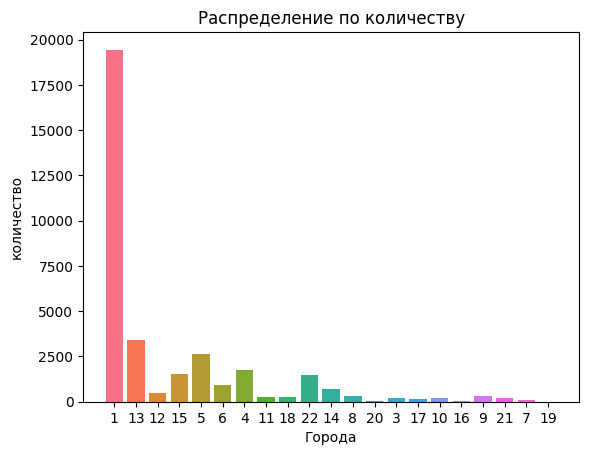

In [57]:
members_total = dict(Counter(members.city))

ind = np.arange(len(members_total))
palette = sns.color_palette("husl", len(members_total))

plt.bar(ind, list(members_total.values()), color=palette)
plt.xticks(ind, list(members_total.keys()))
plt.title('Распределение по количеству')
plt.xlabel('Города')
plt.ylabel('количество')
plt.show()

Больше всего слушателей из города 1, далее идут города 13 и 5

**Распределение по возрастам**

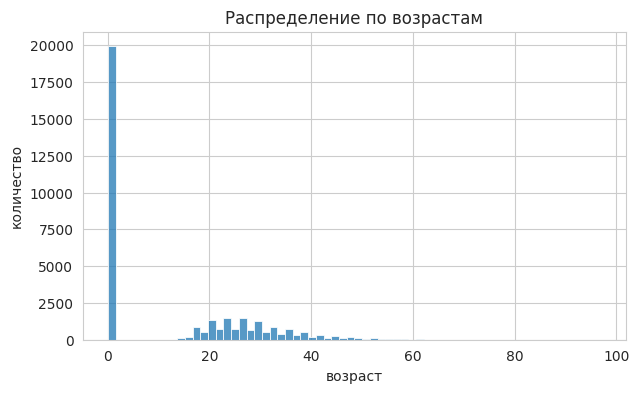

In [58]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(7, 4))
    hist = sns.histplot(data=members[(members['bd']>-1) & (members['bd']<100)], x='bd')


    plt.title('Распределение по возрастам')
    plt.xlabel('возраст')
    plt.ylabel('количество')

Выброс в точке 0 значит, что по умолчанию возраст стоит 0, и большинство людей его не поменяли

Построим без выброса

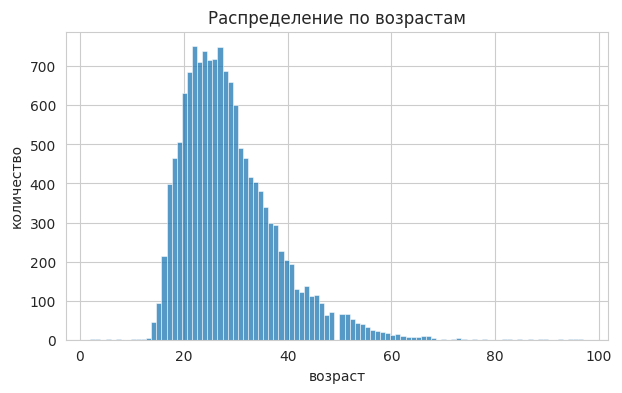

In [59]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(7, 4))
    hist = sns.histplot(data=members[(members['bd']>0) & (members['bd']<100)], x='bd')


    plt.title('Распределение по возрастам')
    plt.xlabel('возраст')
    plt.ylabel('количество')

Теперь мы видим, что пик приходится на 25 лет, и людей старше 70 очень мало

**Таким образом**, данные, в целом, адекватные. Далее проведем все необходимые преобразования для каждой модели.

#Исследование моделей

Глобально опробуем 3 подхода:

1) Закодировать категориальные фичи и использовать решающие деревья для ранжирования.

2) Использовать коллаборативную фильтрацию. Попробуем kNN, Implicit ALS.

3) Попробуем нейронные сети для извлечения эмбеддингов. Здесь тоже будет 2 подхода: Первый вариант - это Item2Vec и User2vec подход(за основу возьмем Word2Vec), а дальше рекомендовать по сходству пользователей и объектов соответственно. Второй вариант - использовать больше дополнительной информации и подать характеристики пользователей и айтемов на вход feature extractor. Далее с этими эмбеддингами смотреть либо косинусную меру, либо объединять их и опять подавать на вход xgboost(остальные в среднем выдают точность ниже)

##1ый подход:

Получим векторное представление для каждого юзера и айтема по отдельности:

Рассмотрим всех пользователей. Гендер мы решили не использовать, чтобы не добавлять новые зависимости при восставновлении. Остальные колонки практически польностью заполнены, поэтому просто выкинем Nan. Других категориальных незакодированных признаков в members нет. Получим численное представление дат в днях и отнормируем их.

In [14]:
members = members.drop(columns=['gender'])
members = members.dropna()

members['registration_init_time'] = pd.to_datetime(members['registration_init_time'], format="%Y%m%d")
members['expiration_date'] = pd.to_datetime(members['expiration_date'], format="%Y%m%d")

registration_init_min = members['registration_init_time'].min()
expiration_date_min = members['expiration_date'].min()

members['registration_init_time'] = members['registration_init_time'].apply(lambda x: np.float16((x - registration_init_min).days))
members['expiration_date'] = members['expiration_date'].apply(lambda x: np.float16((x - expiration_date_min).days))

In [15]:
min_max_scaler = MinMaxScaler()

members['registration_init_time'] = min_max_scaler.fit_transform(members['registration_init_time'].to_numpy().reshape(-1, 1))
members['expiration_date'] = min_max_scaler.fit_transform(members['expiration_date'].to_numpy().reshape(-1, 1))

members.head()

,msno,city,bd,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,7,0.572754,0.938965
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,7,0.871094,0.934570
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,4,0.932129,0.935547
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,9,0.885254,0.899414
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,4,0.993164,0.933594


Теперь получим вектор для каждой песни.

Вначале удалим выбросы и отнормируем длину песен(больше численных фичей нету).

In [16]:
songs_full_info = songs_full_info.drop(columns=['genre_ids'])
songs_full_info = songs_full_info.dropna()

min_max_scaler = MinMaxScaler()

songs_full_info['song_length'] = min_max_scaler.fit_transform(songs_full_info['song_length'].to_numpy().reshape(-1, 1))

Закодируем категориальные фичи:

In [17]:
categorical_unencoded_features = ['artist_name', 'composer', 'lyricist', 'name', 'isrc']

songs_full_info[categorical_unencoded_features] = songs_full_info[categorical_unencoded_features].apply(LabelEncoder().fit_transform)

In [18]:
songs_full_info.head()

,song_id,song_length,artist_name,composer,lyricist,language,name,isrc
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,0.027632,27869,100096,87847,3.0,176979,175063
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,0.030528,19016,97985,92155,3.0,166960,178711
7,GsCpr618xfveHYJdo+E5SybrpR906tsjLMeKyrCNw8s=,0.030890,27065,91467,92122,3.0,185251,165084
8,oTi7oINPX+rxoGp+3O6llSltQTl80jDqHoULfRoLcG4=,0.025508,28431,37262,82162,3.0,184850,169385
9,btcG03OHY3GNKWccPP0auvtSbhxog/kllIIOx5grE/k=,0.025955,12006,77008,74232,52.0,118953,61686


Сохраним датасеты с признаками пользователей и айтемов.

In [19]:
songs_full_info.to_csv('songs_embs.csv', index=False)
members.to_csv('members_embs.csv', index=False)

Теперь создадим train датасет. Для этого объединим наши значения в пары user-item. Заметим, что мы хотим делать рекомендации для кажого пользователя, а в них могут попадать и треки не из датасета пар user-item. Поэтому не будем брать в рассчет признаки для пар из data(иначе нельзя будет на вход XGBRanker подать вектор не из пар).

In [20]:
data = data[['msno', 'song_id', 'target']]

data = pd.merge(data, members, on='msno', how='left')
data = pd.merge(data, songs_full_info, on='song_id', how='left')

Подготовим train данные для XGBRanker. Для этого закодируем все Id в индексы.

In [21]:
data = data.dropna()

users_arr = data["msno"].nunique()
songs_arr = data["song_id"].nunique()

user_to_idx = dict(zip(np.unique(data["msno"]), list(range(users_arr))))
song_to_idx = dict(zip(np.unique(data["song_id"]), list(range(songs_arr))))
idx_to_user = dict(zip(list(range(users_arr)), np.unique(data["msno"])))
idx_to_song = dict(zip(list(range(songs_arr)), np.unique(data["song_id"])))

data["msno"] = data["msno"].apply(lambda x: user_to_idx[x])
data["song_id"] = data["song_id"].apply(lambda x: song_to_idx[x])

data.head()

,msno,song_id,target,city,bd,registered_via,registration_init_time,expiration_date,song_length,artist_name,composer,lyricist,language,name,isrc
6,16761,41291,1,13,24,9,0.554199,0.938965,0.025660,2094.0,78789.0,75887.0,31.0,179963.0,169455.0
11,27267,12669,1,15,26,9,0.589355,0.948242,0.025058,27422.0,92718.0,89687.0,3.0,186826.0,184735.0
12,14484,71098,0,1,0,9,0.879395,0.939941,0.031257,28431.0,96453.0,93924.0,3.0,169908.0,169572.0
13,2572,38634,1,5,0,9,0.534668,0.938965,0.028286,27356.0,92522.0,89439.0,3.0,182029.0,185774.0
14,14484,25383,1,1,0,9,0.879395,0.939941,0.023468,28431.0,37262.0,49554.0,3.0,188959.0,169892.0


Теперь разделим датасет на train и test.

In [22]:
data_train, data_test = train_test_split(data, test_size=0.2, shuffle=True)
data_train.shape, data_test.shape

((3127370, 15), (781843, 15))

Теперь для XGBranker необходимо определить groups, eval_set, eval_group.

In [24]:
X_train = data_train.drop(columns=['target'])
y_train = data_train['target'].to_numpy()

X_test = data_test.drop(columns=['target'])
y_test = data_test['target'].to_numpy()

Так как нам нужно для каждого пользователя предсказывать треки, то оставим набор признаков, по которым мы будем ранжировать. Поэтому нам не нужны в векторе Id песен, а только характеристики для каждой.

In [29]:
groups = data_train['msno'].value_counts().sort_index()

eval_set = [(X_train.drop('song_id', axis=1), y_train),
            (X_test.drop('song_id', axis=1), y_test)]

eval_group = [X_train['msno'].value_counts().sort_index(),
              X_test['msno'].value_counts().sort_index()]

Попробуем XGboost, так как на нем обычно точность предсказаний немного выше, чем на остальных. А вектора получим из числовых значений и категориальных, закодированных с помощью LabelEncoder.

In [30]:
ranker = xgb.XGBRanker(
    tree_method="hist",
    booster='gbtree',
    lambdarank_num_pair_per_sample=8,
    objective="rank:ndcg",
    lambdarank_pair_method="topk",
    max_depth=6)

Обучим модель:

In [ ]:
ranker.fit(X=X_train.drop('song_id', axis=1),
           y=y_train,
           group=groups,
           eval_set=eval_set,
           eval_group=eval_group,
           eval_metric='ndcg@20',
           verbose=False)

evals_result = ranker.evals_result()

In [46]:
print('train NDCG@20 score: ', np.mean(evals_result['validation_0']['ndcg@20']))
print('test NDCG@20 score: ', np.mean(evals_result['validation_1']['ndcg@20']))

train NDCG@20 score:  0.7750343441801406
test NDCG@20 score:  0.8203252458244168


Такми образом, мы получили очень неплохое значение на тестовой выборке: 0.8203252458244168.

##2ой подход:

В этом подходе нам не не нужны никакие дополнительные фичи, поэтому скопируем датасет с нужными колонками.

In [65]:
data_collaborative = data[['msno', 'song_id', 'target']]
data_collaborative.head()

,msno,song_id,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,1


Разделим data на train и test, чтобы была возможность посчитать ndcg@20. Возьмем очень большую часть в качетсве test, чтобы у нас как можно больше рекомендаций пересекалось с test(для нормального подсчеста метрик).

In [66]:
data_train, data_test = train_test_split(data_collaborative, test_size=0.45, shuffle=True)
data_train.shape, data_test.shape

((4057579, 3), (3319839, 3))

Теперь создадим csr матрицу(c индексами юзеров и колонками айтемов). Причем учтем, что матрица должна быть размерности всех уникальных юзеров на все уникальные айтемы(включая test, но там все значения target равны 0).

In [67]:
def create_csr_matrix(dataframe):
    users_arr = dataframe["msno"].nunique()
    songs_arr = dataframe["song_id"].nunique()

    user_to_idx = dict(zip(np.unique(dataframe["msno"]), list(range(users_arr))))
    song_to_idx = dict(zip(np.unique(dataframe["song_id"]), list(range(songs_arr))))
    idx_to_user = dict(zip(list(range(users_arr)), np.unique(dataframe["msno"])))
    idx_to_song = dict(zip(list(range(songs_arr)), np.unique(dataframe["song_id"])))

    user_idxes = [user_to_idx[i] for i in dataframe["msno"]]
    song_idxes = [song_to_idx[i] for i in dataframe["song_id"]]
    df_csr_matrix = csr_matrix((dataframe["target"], (user_idxes, song_idxes)), shape=(users_arr, songs_arr))

    return df_csr_matrix, user_to_idx, song_to_idx, idx_to_user, idx_to_song

Нам нужно создать словарь со всеми пользователями и песнями, при этом  не добавив данные из test в csr матрицу. Для этого сд

In [68]:
test_all_zeroes = data_test.copy()
test_all_zeroes = test_all_zeroes.replace(1, 0)

frames = [data_train, test_all_zeroes]
tmp_df = pd.concat(frames)

In [69]:
csr_matrix, user_to_idx, song_to_idx, idx_to_user, idx_to_song = create_csr_matrix(tmp_df)

del tmp_df
del test_all_zeroes

In [70]:
csr_matrix.shape

(30755, 359966)

Таким образом мы получили разреженную матрицу. Проверим соответсвие размеров и посмотрим сколько у нее столбцов(уникальных песен) и строк(уникальных юзеров):

In [71]:
assert len(user_to_idx) == len(idx_to_user), "wrong dict size"
assert len(song_to_idx) == len(idx_to_song), "wrong dict size"

print("rows: ", len(user_to_idx))
print("cols: ", len(song_to_idx))

rows:  30755
cols:  359966


Для тестовой части для каждого юзера добавим релевантные треки.

In [72]:
data_test['msno'] = data_test['msno'].apply(lambda x: user_to_idx[x])
data_test['song_id'] = data_test['song_id'].apply(lambda x: song_to_idx[x])

data_test = data_test[data_test['target'] == 1].groupby('msno')['song_id'].apply(list).reset_index()
data_test = pd.DataFrame({'msno': data_test['msno'], 'relevant': data_test['song_id']})
data_test = data_test.sort_values(by='msno')

data_test.head()

,msno,relevant
0,0,"[87193, 51546, 120634, 33578, 331022, 263188, ..."
1,1,"[237015, 5607, 257186, 125755, 263868, 219276,..."
2,2,"[172241, 106432, 192698, 60097, 16306, 275122,..."
3,4,"[30692, 275289, 181045, 343873, 236626, 254583..."
4,6,"[35888, 316739, 75185, 286934, 192278, 9058, 8..."


###kNN Model

Заемтим, что в данном случае у нас всего около 30 000 юзеров. При этом около 360 000 айтемов. Поэтому в данном случаем имеет смысл искать похожие друг на друга песни. Поэтому займемся Item2Item рекомендациями. Для этого сделаем для каждого пользователя из train список релевантных треков по аналогии с test.

In [73]:
data_train['msno'] = data_train['msno'].apply(lambda x: user_to_idx[x])
data_train['song_id'] = data_train['song_id'].apply(lambda x: song_to_idx[x])

data_train = data_train[data_train['target'] == 1].groupby('msno')['song_id'].apply(list).reset_index()
data_train = pd.DataFrame({'msno': data_train['msno'], 'relevant': data_train['song_id']})
data_train = data_train.sort_values(by='msno')

data_train.head()

,msno,relevant
0,0,"[50872, 69703, 237406, 53323, 235979, 76274, 1..."
1,1,"[74185, 160914, 231935, 11835, 350625, 136455,..."
2,2,"[208464, 11771, 136590, 105885, 89514, 344690,..."
3,3,[91646]
4,4,"[66650, 332099, 110996, 331761, 31455, 222222,..."


Также нам придется транспонировать разреженную матрицу.

In [75]:
item_user_matrix = csr_matrix.transpose().tocsr()

Обучим модель. В качестве оптимального k возьмем 5.

In [132]:
def train_knn(k=5, metric='cosine'):
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(item_user_matrix)
    return kNN

Вначале в качестве расстояния возьмем косинусное.

In [133]:
kNN = train_knn(metric='cosine')

Напишем функцию предсказания айтемов для каждого пользователя:

In [239]:
def find_similar_songs(song_idx, kNN, N_neighb=20):
    song_vec = item_user_matrix[song_idx]
    if isinstance(song_vec, (np.ndarray)):
        song_vec = song_vec.reshape(1,-1)

    distances, indices = kNN.kneighbors(song_vec, n_neighbors=N_neighb)
    distances = distances.ravel()
    indices = indices.ravel()
    return dict(zip(distances, indices))

In [240]:
def recommend_for_user(user_idx, kNN, N_neighb=20):
    if not(user_idx in data_train['msno'].values):
        return np.asarray([])

    train_relevant = data_train[data_train['msno'] == user_idx]['relevant']
    if train_relevant.empty:
        return np.asarray([])

    recommendations = {}
    for song_idx in train_relevant.iloc[0]:
        nearest_for_song = find_similar_songs(song_idx, kNN, N_neighb=N_neighb)
        for dist, ind in nearest_for_song.items():
            if ind not in recommendations or recommendations[ind] > dist:
                recommendations[ind] = dist

        sorted_recommendations = sorted(recommendations.items(), key=lambda x: x[1])
        top_recommendations = dict(sorted_recommendations[:N_neighb])

    return np.asarray(list(top_recommendations.keys()))

Построим предсказания для каждого пользователя из тестовой выборки. Заметим, что у части юзеров релевантных айтемов больше 20. Для них добьем предсказания 0 до их количества, так как все равно счиаться будут только первые 20. Для тех, где меньше 20 релевантных, дополним их до 20 нулями, так как получается, что юзер просто другие не считает подходящими.

In [149]:
def calc_ndcg(recomendations, relevant, k=20):
    if len(recomendations) < len(relevant):
        recomendations = np.concatenate((recommendations, np.zeros(len(relevant) - len(recomendations))))
    if len(relevant) < len(recomendations):
        relevant = np.concatenate((relevant, np.zeros(len(recomendations) - len(relevant))))

    return ndcg_score([relevant], [recomendations], k = 20)

In [243]:
def predict_for_all_users(kNN):
    ncdg_values = np.asarray([])

    for index, row in data_test.iterrows():
        user_idx = int(row['msno'])
        recomendations = recommend_for_user(user_idx, kNN)
        relevant = np.asarray(row['relevant'])

        ndcg_user = calc_ndcg(recommendations, relevant, 20)
        ncdg_values = np.concatenate((ncdg_values, np.asarray([ndcg_user])))

    return ncdg_values

Выведем значения метриик на тестовой части:

In [237]:
ncdg_values = predict_for_all_users(kNN)

print('max ndcg@20 score: ', ncdg_values.max())
print('min ndcg@20 score: ', ncdg_values.min())
print('mean ndcg@20 score: ', ncdg_values.sum()/len(ncdg_values))

max ndcg@20 score:  0.8266025669447897
min ndcg@20 score:  0.513654425351991
mean ndcg@20 score:  0.6157212998635732


Теперь для kNN в качестве расстояния попробуем Евкидову метрику:

In [238]:
kNN_euclidean = train_knn(metric='euclidean')

Получим предсказания и метрики для каждого пользователя в этом случае:

In [244]:
ncdg_values = predict_for_all_users(kNN_euclidean)

print('max ndcg@20 score: ', ncdg_values.max())
print('min ndcg@20 score: ', ncdg_values.min())
print('mean ndcg@20 score: ', ncdg_values.sum()/len(ncdg_values))

max ndcg@20 score:  0.8178623901323531
min ndcg@20 score:  0.5136770548234971
mean ndcg@20 score:  0.6544712652880724


Остальные хоть сколько-то отличающиеся метрики не подходят для разреженных матриц, поэтому остановимся на этих двух. Лучший скор у kNN с евклидовым расстоянием(0.6544712652880724).

###Implicit ALS Model

In [22]:
!pip install implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 20.3 MB/s eta 0:00:00


Загрузим модель. Больше 15 итераций ставить смысла не имеет, так как уже на двух средний по пользователям ndcg@20 равен 0.5697736216145952.

In [44]:
import implicit

model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.01, iterations=15)

И обучим ее на разреженной матрице:

In [45]:
model.fit(csr_matrix)

  0%|          | 0/15 [00:00<?, ?it/s]

Посчитаем метрику для каждого пользователя:

In [47]:
ncdg_values = np.asarray([])

for index, row in data_test.iterrows():
    user_idx = int(row['msno'])
    recommendations = model.recommend(user_idx, csr_matrix[user_idx], N=20)[0]
    relevant = np.asarray(row['relevant'])

    ndcg_user = calc_ndcg(recommendations, relevant, 20)
    ncdg_values = np.concatenate((ncdg_values, np.asarray([ndcg_user])))

Посмотрим на среднее по пользователям значение, а также на максимум и минимум:

In [50]:
print('max ndcg@20 score: ', ncdg_values.max())
print('min ndcg@20 score: ', ncdg_values.min())
print('mean ndcg@20 score: ', ncdg_values.sum()/len(ncdg_values))

max ndcg@20 score:  1.0
min ndcg@20 score:  0.2276702486969526
mean ndcg@20 score:  0.5715601847466224


**Подводя итог**, можно сказать, что коллаборативный подход дает в целом неплохое значение метрики ndcg@20(для некоторых пользователей с очень большой историей он предсказывает практически все треки правильно(не рекомендует неправильные)). При этом факторизация показала себя хуже в сравнении с kNN. То есть в отсутствии допольнительных признаков эмбеддинги извлекаются не очень хорошо. И лучше оказыввается подход Item2Item(особенно для пользователей с большой историей взаимодествия). В нем лучшее среднее значение ndcg@20 равно 0.6544712652880724.

##3ий подход:

Из того, что я успел - это идея применить Word2Vec к айтемам, как к словам. Тогда поотом будем их ранжировать по их схожести.

In [60]:
data_collaborative = data[['msno', 'song_id', 'target']]
data_collaborative.head()

,msno,song_id,target
6,16761,41291,1
11,27267,12669,1
12,14484,71098,0
13,2572,38634,1
14,14484,25383,1


In [61]:
data_train, data_test = train_test_split(data_collaborative, test_size=0.2, shuffle=True)
data_train.shape, data_test.shape

((3127370, 3), (781843, 3))

In [62]:
users_arr = data_train["msno"].nunique()
songs_arr = data_train["song_id"].nunique()

user_to_idx = dict(zip(np.unique(data_train["msno"]), list(range(users_arr))))
song_to_idx = dict(zip(np.unique(data_train["song_id"]), list(range(songs_arr))))
idx_to_user = dict(zip(list(range(users_arr)), np.unique(data_train["msno"])))
idx_to_song = dict(zip(list(range(songs_arr)), np.unique(data_train["song_id"])))

In [63]:
data_train['msno'] = data_train['msno'].apply(lambda x: user_to_idx[x])
data_train['song_id'] = data_train['song_id'].apply(lambda x: song_to_idx[x])

data_train_relevant = data_train[data_train['target'] == 1].groupby('msno')['song_id'].apply(list).reset_index()
data_train_relevant = pd.DataFrame({'msno': data_train_relevant['msno'], 'relevant': data_train_relevant['song_id']})
data_train_relevant = data_train_relevant.sort_values(by='msno')

data_train_relevant.head()

,msno,relevant
0,0,"[43980, 38175, 56819, 17672, 1283, 7529, 43964..."
1,1,"[57593, 65543, 33663, 67558, 25285, 36388, 149..."
2,2,"[68087, 27415, 15709, 69257, 20316, 47041, 552..."
3,3,[18415]
4,4,"[33936, 21926, 68087, 6340, 15578, 71479, 6141..."


In [64]:
data_train_unrelevant = data_train[data_train['target'] == 0].groupby('msno')['song_id'].apply(list).reset_index()
data_train_unrelevant = pd.DataFrame({'msno': data_train_unrelevant['msno'], 'unrelevant': data_train_unrelevant['song_id']})
data_train_unrelevant = data_train_unrelevant.sort_values(by='msno')

data_train_unrelevant.head()

,msno,unrelevant
0,0,"[26846, 47613, 21184, 47687, 14125, 18355, 149..."
1,1,"[40849, 25369, 52383, 57442, 64200, 12425, 403..."
2,2,"[19611, 57456, 37605, 46285, 22191, 57676, 194..."
3,3,"[16907, 47684, 17355, 33660, 33865, 1283, 2977..."
4,4,"[2610, 48467, 63025, 25843, 70432, 23789, 3592..."


In [65]:
song_id_groups = list(data_train_relevant['relevant']) + list(data_train_unrelevant['unrelevant'])
len(song_id_groups)

54575

In [ ]:
# к сожалению я не успел :(

Вывод:

Сравнивая между собой разные методы, можно сказать, что все-таки коллаборативная фильтрация сильно проигрывает подходу, где используются допольнительно характеристики объектов. Самое большое значение метрики у меня получилось : 0.8203252458244168.